In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Завантаження даних
data = pd.read_csv("df_file.csv")
texts = data['Text']
labels = data['Label']

# Розділення даних
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Токенізація та перетворення тексту в послідовності
max_words = 10000  # Максимальна кількість слів у токенізаторі
max_len = 100  # Максимальна довжина тексту
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# One-hot encoding для міток
encoder = LabelBinarizer()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Побудова моделі
model_scratch = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dense(5, activation='softmax')  # 5 категорій
])

model_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Навчання
history_scratch = model_scratch.fit(
    X_train_seq, y_train_enc,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


Epoch 1/10
45/45 [==============================] - 7s 102ms/step - loss: 1.5446 - accuracy: 0.2542 - val_loss: 1.2564 - val_accuracy: 0.4888
Epoch 2/10
45/45 [==============================] - 4s 90ms/step - loss: 1.0917 - accuracy: 0.6236 - val_loss: 0.8934 - val_accuracy: 0.7163
Epoch 3/10
45/45 [==============================] - 4s 95ms/step - loss: 0.6145 - accuracy: 0.8174 - val_loss: 0.6130 - val_accuracy: 0.8090
Epoch 4/10
45/45 [==============================] - 4s 96ms/step - loss: 0.2652 - accuracy: 0.9347 - val_loss: 0.4660 - val_accuracy: 0.8567
Epoch 5/10
45/45 [==============================] - 4s 94ms/step - loss: 0.1053 - accuracy: 0.9761 - val_loss: 0.5058 - val_accuracy: 0.8708
Epoch 6/10
45/45 [==============================] - 4s 92ms/step - loss: 0.3334 - accuracy: 0.9213 - val_loss: 0.5586 - val_accuracy: 0.8146
Epoch 7/10
45/45 [==============================] - 4s 95ms/step - loss: 0.0751 - accuracy: 0.9909 - val_loss: 0.4804 - val_accuracy: 0.8792
Epoch 8/10
4

In [4]:
# Завантаження попередньо натренованих векторів  GloVe
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f: 
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Побудова матриці embedding
embedding_dim = 100  # Розмір векторів у GloVe
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Побудова моделі
model_pretrained = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
    LSTM(128, return_sequences=False),
    Dense(5, activation='softmax')
])

model_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Навчання
history_pretrained = model_pretrained.fit(
    X_train_seq, y_train_enc,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


Epoch 1/10
45/45 [==============================] - 6s 78ms/step - loss: 1.2050 - accuracy: 0.5154 - val_loss: 0.7651 - val_accuracy: 0.7725
Epoch 2/10
45/45 [==============================] - 3s 66ms/step - loss: 0.6444 - accuracy: 0.7893 - val_loss: 0.5020 - val_accuracy: 0.8427
Epoch 3/10
45/45 [==============================] - 3s 67ms/step - loss: 0.5297 - accuracy: 0.8153 - val_loss: 0.5232 - val_accuracy: 0.8230
Epoch 4/10
45/45 [==============================] - 3s 65ms/step - loss: 0.4124 - accuracy: 0.8631 - val_loss: 0.3557 - val_accuracy: 0.8904
Epoch 5/10
45/45 [==============================] - 3s 65ms/step - loss: 0.4326 - accuracy: 0.8652 - val_loss: 0.4006 - val_accuracy: 0.8848
Epoch 6/10
45/45 [==============================] - 3s 65ms/step - loss: 0.3674 - accuracy: 0.8820 - val_loss: 0.4227 - val_accuracy: 0.8483
Epoch 7/10
45/45 [==============================] - 3s 66ms/step - loss: 0.3098 - accuracy: 0.8996 - val_loss: 0.2808 - val_accuracy: 0.9185
Epoch 8/10
45

In [5]:
# Оцінка на тестових даних
test_loss_scratch, test_acc_scratch = model_scratch.evaluate(X_test_seq, y_test_enc)
test_loss_pretrained, test_acc_pretrained = model_pretrained.evaluate(X_test_seq, y_test_enc)

print(f"From Scratch - Test Accuracy: {test_acc_scratch}")
print(f"Pretrained Embeddings - Test Accuracy: {test_acc_pretrained}")


14/14 [==============================] - 0s 25ms/step - loss: 0.3038 - accuracy: 0.9079
From Scratch - Test Accuracy: 0.8494381904602051
Pretrained Embeddings - Test Accuracy: 0.9078651666641235


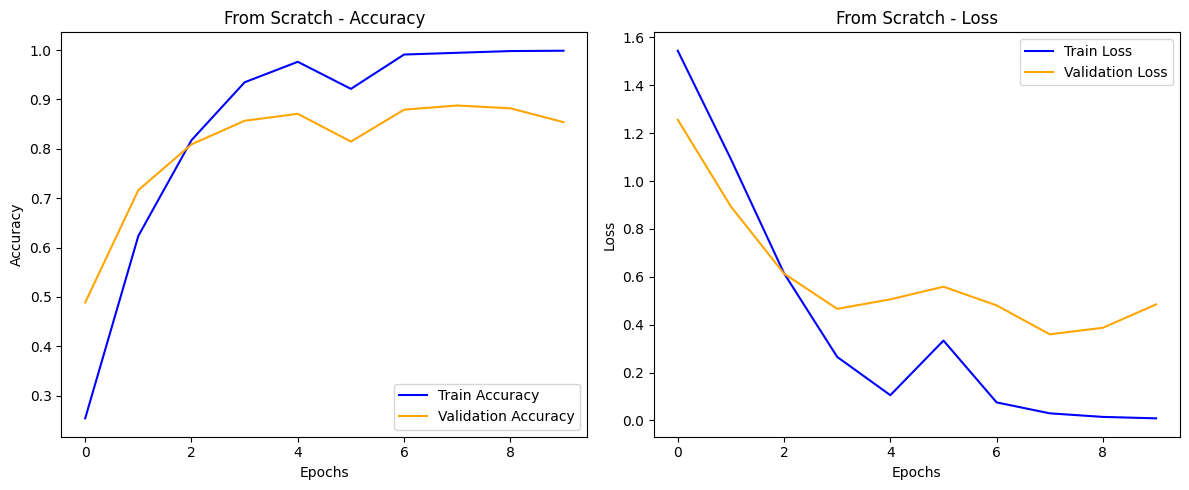

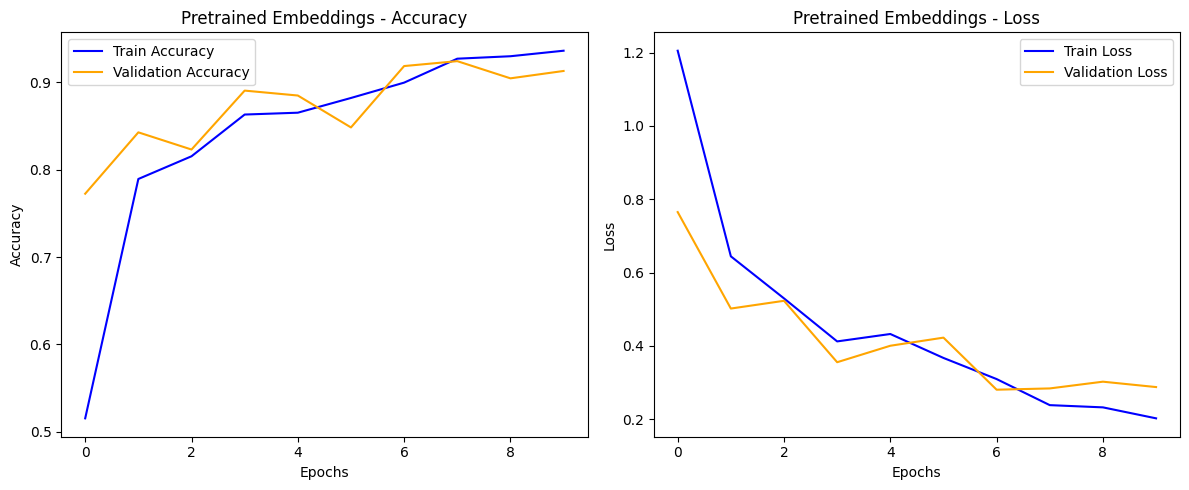

In [6]:
import matplotlib.pyplot as plt

# Функція для побудови графіків точності та втрат
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    
    # Графік точності
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Графік втрат
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Візуалізація результатів для обох моделей
plot_training_history(history_scratch, "From Scratch")
plot_training_history(history_pretrained, "Pretrained Embeddings")
